# locate variants & non-synonymous variants and calculate dn/dS from SAMFIRE output

put full path to single_locus_trajectories.out file and full path to reference .dat file below

In [206]:
#input variant paths

# path to Single_locus_trajectories.out file
variant_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Single_locus_trajectories10.out"
println(variant_path)

# path to Reading_Frames.dat file
ref_dat_path = "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat"
println(ref_dat_path)

/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/Single_locus_trajectories10.out
/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames.dat


In [207]:
#load dependencies as quietly as possible

# load Julia dependencies
using DataFrames
using CategoricalArrays
using RCall
using FileIO  
using Images
using Distributions
using Optim
using Roots

# Load R dependencies
R"""
# Function to set CRAN mirror and ensure R can download packages
chooseCRANmirror(ind=1) # Selects a default CRAN mirror

# Check and load the BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
end

# Function to handle permission issues and force reinstall if needed
install_if_missing <- function(pkg) {
  if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
    BiocManager::install(pkg, ask = FALSE, force = TRUE)
  }
}

# Apply function to Biostrings, and install ggplot2 and viridis with dependencies
install_if_missing("Biostrings")
install_if_missing("BiocGenerics")
install.packages(c("ggplot2", "viridis", "tidyverse"), dependencies = TRUE)

# Load the packages quietly
suppressPackageStartupMessages({
  library("Biostrings")
  library("ggplot2")
  library("viridis")
  library("tidyverse")
})
"""



The downloaded binary packages are in
	/var/folders/7v/htx5jcb93rvbnyr12j89csbr0000gp/T//RtmpX4IFyu/downloaded_packages


┌ Warning: RCall.jl: Installing packages into '/Users/e.smith.5/Library/R/arm64/4.4/library'
│ (as 'lib' is unspecified)
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/ggplot2_3.5.1.tgz'
│ Content type 'application/x-gzip' length 4974305 bytes (4.7 MB)
│ ==================================================
│ downloaded 4.7 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/viridis_0.6.5.tgz'
│ Content type 'application/x-gzip' length 3016921 bytes (2.9 MB)
│ ==================================================
│ downloaded 2.9 MB
│ 
│ trying URL 'https://cloud.r-project.org/bin/macosx/big-sur-arm64/contrib/4.4/tidyverse_2.0.0.tgz'
│ Content type 'application/x-gzip' length 428901 bytes (418 KB)
│ ==================================================
│ downloaded 418 KB
│ 
└ @ RCall ~/.julia/packages/RCall/dDAVd/src/io.jl:172


RObject{StrSxp}
 [1] "lubridate"    "forcats"      "stringr"      "dplyr"        "purrr"       
 [6] "readr"        "tidyr"        "tibble"       "tidyverse"    "viridis"     
[11] "viridisLite"  "ggplot2"      "Biostrings"   "GenomeInfoDb" "XVector"     
[16] "IRanges"      "S4Vectors"    "stats4"       "BiocGenerics" "stats"       
[21] "graphics"     "grDevices"    "utils"        "datasets"     "methods"     
[26] "base"        


In [208]:
# read variants file into a dataframe

# Define the function to read the .out file
function read_out_file(filepath::String)
    # Initialize an empty DataFrame
    df = DataFrame(pos = Int[], original_base = String[], variant_base = String[])
    
    # Open the file and process each line
    open(filepath, "r") do file
        for line in eachline(file)
            # Remove any leading/trailing whitespace
            stripped_line = strip(line)
            
            # Continue only if the line is not empty
            if !isempty(stripped_line)
                # Split the line into parts, typically space-delimited
                parts = split(stripped_line)
                
                # Ensure there are enough parts to avoid index errors
                if length(parts) < 3
                    continue  # Skip this line if it doesn't have enough parts
                end

                # Extract the position, original base, and variant base
                pos = parse(Int, parts[1])
                original_base = parts[2]  # Should be a single character string
                variant_base = parts[3]   # Should be a single character string
                
                # Append to the DataFrame
                push!(df, (pos, original_base, variant_base))
            end
        end
    end
    
    return df
end

variants = read_out_file(variant_path)

# create a column with mutation directions e.g. A->T

function call_muts(df::DataFrame)
    # Check if the required columns are present in the DataFrame
    if !("original_base" in names(df) && "variant_base" in names(df))
        error("DataFrame must contain 'original_base' and 'variant_base' columns")
    end

    # Create a new column 'mutation' by concatenating 'original_base', '->', 'variant_base'
    mutations = df.original_base .* "->" .* df.variant_base

    # Define the order of categories
    levels_order = ["A->C", "A->G", "A->T", "C->A", "C->G", "C->T", "G->A", "G->C", "G->T", "T->A", "T->C", "T->G"]

    # Convert 'mutations' into a categorical array with predefined levels
    df.mutation = categorical(mutations, ordered=true, levels=levels_order)
    
    return df
end

variants = call_muts(variants)

Row,pos,original_base,variant_base,mutation
,Int64,String,String,Cat…
1,11,A,G,A->G
2,18,A,G,A->G
3,141,G,A,G->A
4,144,G,T,G->T
5,380,T,C,T->C
6,576,G,A,G->A
7,754,A,G,A->G
8,811,C,T,C->T
9,977,C,A,C->A


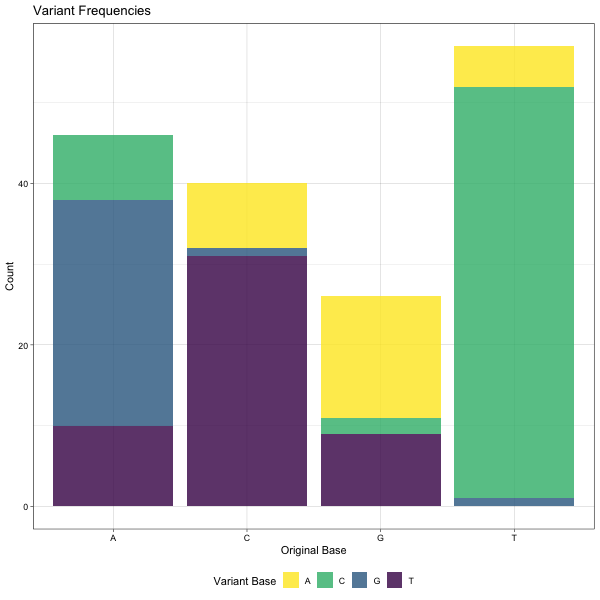

Temporary file deleted successfully.


In [209]:
# barplot of mutation frequencies

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- ggplot(variants, aes(x = original_base, fill = variant_base)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variant Frequencies", x = "Original Base", y = "Count", fill = "Variant Base") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1)

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


In [210]:
# pull two .fas from .dat file 

# Function to handle the .dat file processing
function pull_frames(dat_file_path::String)
    # Define the paths for the .fa files in Julia before calling R
    nucleotide_fasta_path = replace(dat_file_path, ".dat" => "_nucleotide.fa")
    aa_fasta_path = replace(dat_file_path, ".dat" => "_amino_acid.fa")

    # Pass the file paths to R
    @rput dat_file_path
    @rput nucleotide_fasta_path
    @rput aa_fasta_path

    R"""
    library(Biostrings)
    library(stringr)
    process_file <- function(dat_file_path, fasta_nucleotide_path, fasta_amino_acid_path) {
        lines <- tryCatch({
            readLines(dat_file_path)
        }, error = function(e) {
            cat("Error reading file:", e$message, "\n")
            return(NULL)  # Return NULL to handle error gracefully
        })
        if (is.null(lines)) return()  # Exit if file could not be read

        con_nuc <- file(fasta_nucleotide_path, open = "w")
        con_aa <- file(fasta_amino_acid_path, open = "w")
        
        for (i in seq(1, length(lines), by = 3)) {
            if (i + 2 > length(lines)) {
                break
            }
            header <- strsplit(lines[i], " ")[[1]]
            if (length(header) < 3) {
                next
            }
            start_pos <- header[1]
            end_pos <- header[2]
            annotation <- paste(header[3:length(header)], collapse=" ")
            full_annotation <- paste0('"accession":', start_pos, '..', end_pos, ' | ', annotation)
            dna_seq <- DNAString(lines[i+1])
            aa_seq <- AAString(lines[i+2])
            
            writeLines(paste0(">", full_annotation), con_nuc)
            writeLines(as.character(dna_seq), con_nuc)
            writeLines(paste0(">", full_annotation), con_aa)
            writeLines(as.character(aa_seq), con_aa)
        }
        
        close(con_nuc)
        close(con_aa)
    }
    """
    # Call the R function from Julia with paths
    R"process_file($(dat_file_path), $(nucleotide_fasta_path), $(aa_fasta_path))"
    
    # Julia prints and retains the paths in variables
    println("nucleotide .fa : ", nucleotide_fasta_path)
    println("amino acid .fa : ", aa_fasta_path)

    return nucleotide_fasta_path, aa_fasta_path
end


nucleotide_fasta_path, aa_fasta_path = pull_frames(ref_dat_path)

nucleotide .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa
amino acid .fa : /Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa


("/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_nucleotide.fa", "/Users/e.smith.5/Documents/PhD/RSV_project/RSV_haplotype_reconstruction/data/ref/Reading_Frames_amino_acid.fa")

In [211]:
# read nucleotide .fa file to dataframe 

function pull_fasta(fasta_path::String)
    # Read the fasta file using Biostrings in R
    R"""
    library(Biostrings)
    library(stringr)
    dna_seqs <- readDNAStringSet($(fasta_path))
    headers <- names(dna_seqs)
    
    # Parse headers to extract Accession, Start, End, and Protein
    accession <- str_extract(headers, "^[^:]+")
    range <- str_extract(headers, "\\d+\\.\\.\\d+")
    start <- as.integer(sub("\\.\\..*$", "", range))
    end <- as.integer(sub("^.*\\.\\.", "", range))
    protein <- str_extract(headers, "\\|\\s*(.*)$")
    protein <- str_trim(str_sub(protein, str_locate(protein, "\\|")[[1]] + 1)) # Trim pipe and whitespace
    """

    # Convert R data to Julia DataFrame
    accessions = rcopy(R"accession")
    starts = rcopy(R"start")
    ends = rcopy(R"end")
    proteins = rcopy(R"protein")
    sequences = rcopy(R"sapply(dna_seqs, as.character)")

    # Create a DataFrame from the extracted data
    fasta_df = DataFrame(
        protein = proteins,
        start_pos = starts,
        end_pos = ends,
        sequence = sequences
    )

    return fasta_df
end

fasta_df = pull_fasta(nucleotide_fasta_path)

# add a count of codons for later dN/dS analysis

fasta_df.n_codons .= (length.(fasta_df.sequence) .- 3) ./ 3
fasta_df.n_codons = convert(Array{Int64,1}, fasta_df.n_codons)

println(fasta_df)

11×5 DataFrame
 Row │ protein             start_pos  end_pos  sequence                           n_codons 
     │ String              Int64      Int64    String                             Int64    
─────┼─────────────────────────────────────────────────────────────────────────────────────
   1 │ NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…       139
   2 │ NS2                       606      980  ATGGACACAACACACAATGATACCACACCACA…       124
   3 │ N (Nucleoprotein)        1094     2293  ATGAAAGATGGGGCAAATACAAAAATGGCTCT…       399
   4 │ P (Phosphoprotein)       2325     3050  ATGGAAAAGTTTGCTCCTGAATTCCATGGAGA…       241
   5 │ Matrix                   3233     4003  ATGGAAACATACGTGAATAAACTTCACGAAGG…       256
   6 │ SH protein               4273     4467  ATGGAAAATACATCCATAACTATAGAATTCTC…        64
   7 │ G Glycoprotein           4659     5624  ATGTCCAAAACCAAGGACCAACGCACCGCCAA…       321
   8 │ F Fusion protein         5704     7428  ATGGAGTTGCCAATCCTCAAAACAA

In [212]:
# match proteins by position 

function call_proteins(variants_df::DataFrame, fasta_df::DataFrame)
    # Initialize an empty DataFrame for results, pre-defining the columns by combining both DataFrame's columns
    cols = names(variants_df)
    append!(cols, names(fasta_df))
    result_df = DataFrame(; [Symbol(col) => Any[] for col in cols]...)

    # Iterate over each row in variants_df
    for variant in eachrow(variants_df)
        pos = variant[:pos]  # Accessing the 'pos' column in variants_df

        # Filter fasta_df to find rows where 'pos' is between 'start_pos' and 'end_pos'
        matches = filter(row -> row[:start_pos] <= pos <= row[:end_pos], fasta_df)

        # For each match, concatenate the row from variants_df with the row from fasta_df
        for match in eachrow(matches)
            # Create a new row by extracting the data from both variant and match
            new_row = [variant[coln] for coln in names(variants_df)]
            append!(new_row, [match[coln] for coln in names(fasta_df)])
            push!(result_df, new_row)
        end
    end

    return result_df
end

variants = call_proteins(variants, fasta_df)

# retype columns

# Convert 'pos' to Int64 if it's not already an integer
variants.pos = variants.pos isa AbstractArray{Int} ? variants.pos : parse.(Int, string.(variants.pos))

# Convert 'original_base', 'variant_base', 'mutation', and 'Sequence' to String
variants.original_base = string.(variants.original_base)
variants.variant_base = string.(variants.variant_base)
variants.mutation = string.(variants.mutation)
variants.sequence = string.(variants.sequence)

# Convert 'Protein' to categorical
variants.protein = categorical(variants.protein)

# Convert 'Start' and 'End' to Int64 if they're not already integers
variants.start_pos = variants.start_pos isa AbstractArray{Int} ? variants.start_pos : parse.(Int, string.(variants.start_pos))
variants.end_pos = variants.end_pos isa AbstractArray{Int} ? variants.end_pos : parse.(Int, string.(variants.end_pos))

#add a gene_length column
variants.gene_length .= variants.end_pos .- variants.start_pos

# Print the modified dataframe
println(variants)


147×10 DataFrame
 Row │ pos    original_base  variant_base  mutation  protein             start_pos  end_pos  sequence                           n_codons  gene_length 
     │ Int64  String         String        String    Cat…                Int64      Int64    String                             Any       Int64       
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   141  G              A             G->A      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139               419
   2 │   144  G              T             G->T      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139               419
   3 │   380  T              C             T->C      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139               419
   4 │   754  A              G             A->G      NS2                       6

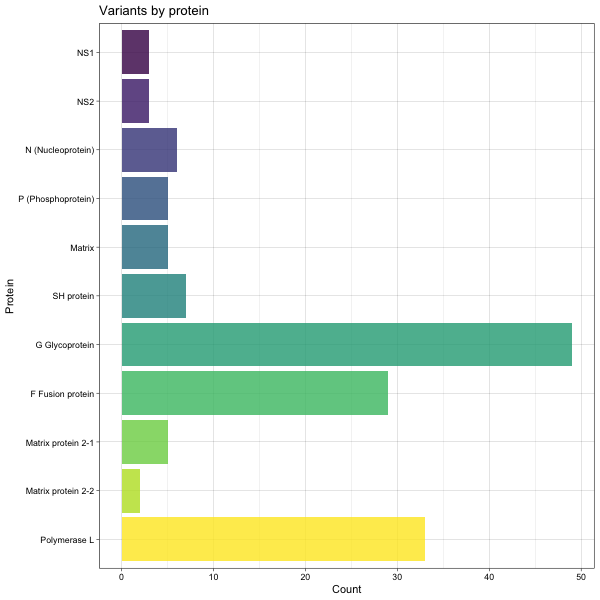

Temporary file deleted successfully.


In [213]:
# barplot of variants by protein

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- variants %>% arrange(desc(start_pos)) %>% 
  mutate(protein = factor(protein, levels = unique(protein))) %>%
  ggplot(aes(x = protein, fill = protein)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variants by protein", x = "Protein", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


In [214]:
# create variant sequence

function substitute_variants(dataframe::DataFrame)
    # Create a new column for Base_Position
    dataframe.adj_pos = dataframe.pos .- dataframe.start_pos

    # Create a new column for variant_sequence
    dataframe.variant_sequence = Vector{String}(undef, nrow(dataframe))

    # Iterate over each row in the DataFrame
    for i in 1:nrow(dataframe)
        # Extract the original sequence
        sequence = string(dataframe[i, :sequence])

        # Extract the variant position
        adjusted_variant_position = dataframe[i, :adj_pos]

        # Check if the variant position is within the sequence length
        if 1 <= adjusted_variant_position <= length(sequence)
            # Extract the variant base
            variant_base = string(dataframe[i, :variant_base])

            # Check if the character at Base_Position is equal to Original_Base
            original_base = string(sequence[adjusted_variant_position])
            if original_base != dataframe[i, :original_base]
                println("Warning: Original_Base in row $i does not match base at position $adjusted_variant_position in the Sequence.")
            end

            # Create the new sequence with the substitution
            new_sequence = string(sequence[1:adjusted_variant_position-1], variant_base, sequence[adjusted_variant_position+1:end])

            # Update the variant_sequence column
            dataframe[i, :variant_sequence] = new_sequence
        end
    end

    return dataframe
end

variants = substitute_variants(variants)

println(variants)

147×12 DataFrame
 Row │ pos    original_base  variant_base  mutation  protein             start_pos  end_pos  sequence                           n_codons  gene_length  adj_pos  variant_sequence                  
     │ Int64  String         String        String    Cat…                Int64      Int64    String                             Any       Int64        Int64    String                            
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   141  G              A             G->A      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139               419       64  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…
   2 │   144  G              T             G->T      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139               419       67  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…
   3 │   3

In [215]:
# Function to split a DNA sequence into codons
function split_into_codons(sequence)
    return [sequence[i:i+2] for i in 1:3:length(sequence)-2]
end

# Function to find original codons
function find_original_codons(df::DataFrame)
    codons = []
    codon_positions = []
    for row in 1:size(df, 1)
        sequence = string(df[row, :sequence])
        base_position = df[row, :adj_pos]

        if base_position < 1 || base_position > length(sequence)
            throw(ArgumentError("Invalid Base_Position for row $row"))
        end

        codon_index = (base_position - 1) ÷ 3 + 1
        codon_position = (base_position - 1) % 3 + 1
        push!(codons, split_into_codons(sequence)[codon_index])
        push!(codon_positions, codon_position)
    end

    df[!, :original_codon] = codons
    df[!, :codon_position] = codon_positions
    df.codon_position = categorical(df.codon_position)
    
    return df
end

# Function to find variant codons
function find_variant_codons(df::DataFrame)
    codons = []
    for row in 1:size(df, 1)
        sequence = string(df[row, :variant_sequence])
        base_position = df[row, :adj_pos]

        if base_position < 1 || base_position > length(sequence)
            throw(ArgumentError("Invalid Base_Position for row $row"))
        end

        codon_index = (base_position - 1) ÷ 3 + 1
        push!(codons, split_into_codons(sequence)[codon_index])
    end

    df[!, :variant_codon] = codons
    
    return df
end

# Function to map codons to amino acids
function codon_to_aa(codon)
    codon_dict = Dict("TTT" => "F", "TTC" => "F", "TTA" => "L", "TTG" => "L",
                      "CTT" => "L", "CTC" => "L", "CTA" => "L", "CTG" => "L",
                      "ATT" => "I", "ATC" => "I", "ATA" => "I", "ATG" => "M",
                      "GTT" => "V", "GTC" => "V", "GTA" => "V", "GTG" => "V",
                      "TCT" => "S", "TCC" => "S", "TCA" => "S", "TCG" => "S",
                      "CCT" => "P", "CCC" => "P", "CCA" => "P", "CCG" => "P",
                      "ACT" => "T", "ACC" => "T", "ACA" => "T", "ACG" => "T",
                      "GCT" => "A", "GCC" => "A", "GCA" => "A", "GCG" => "A",
                      "TAT" => "Y", "TAC" => "Y", "TAA" => "*", "TAG" => "*",
                      "CAT" => "H", "CAC" => "H", "CAA" => "Q", "CAG" => "Q",
                      "AAT" => "N", "AAC" => "N", "AAA" => "K", "AAG" => "K",
                      "GAT" => "D", "GAC" => "D", "GAA" => "E", "GAG" => "E",
                      "TGT" => "C", "TGC" => "C", "TGA" => "*", "TGG" => "W",
                      "CGT" => "R", "CGC" => "R", "CGA" => "R", "CGG" => "R",
                      "AGT" => "S", "AGC" => "S", "AGA" => "R", "AGG" => "R",
                      "GGT" => "G", "GGC" => "G", "GGA" => "G", "GGG" => "G")

    return get(codon_dict, codon, "Unknown")
end

# Function to translate original & variant codons and determine synonymity
function translate_codons(df)
    df.original_aa = map(codon_to_aa, df.original_codon)
    df.variant_aa = map(codon_to_aa, df.variant_codon)
    df.is_synonymous = ifelse.(df.original_aa .== df.variant_aa, "Yes", "No")

    return df
end


# Processing the dataframe through the functions
variants = find_original_codons(variants)
variants = find_variant_codons(variants)
variants = translate_codons(variants)

println(variants)

147×18 DataFrame
 Row │ pos    original_base  variant_base  mutation  protein             start_pos  end_pos  sequence                           n_codons  gene_length  adj_pos  variant_sequence                   original_codon  codon_position  variant_codon  original_aa  variant_aa  is_synonymous 
     │ Int64  String         String        String    Cat…                Int64      Int64    String                             Any       Int64        Int64    String                             Any             Categorical…    Any            String       String      String        
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   141  G              A             G->A      NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…  139      

┌ Warning: RCall.jl: Warning: Removed 1 row containing missing values or values outside the scale range
│ (`geom_bar()`).
└ @ RCall ~/.julia/packages/RCall/dDAVd/src/io.jl:172


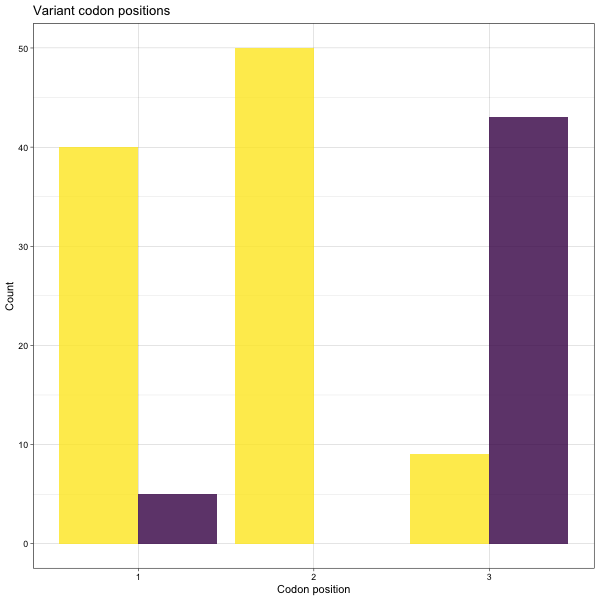

Temporary file deleted successfully.


In [216]:
# barplot of codon positions

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
library(ggplot2)
library(viridis)
library(dplyr)
p <- variants %>% 
  count(codon_position, is_synonymous) %>% # count codon positions for stat=identity in ggplot
  complete(codon_position, is_synonymous) %>% # prevent empty combinations 
  ggplot(aes(x = codon_position, y = n, fill = is_synonymous)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variant codon positions", x = "Codon position", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none")

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [ ]:
# barplot of codon positions by protein

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

R"""
library(ggplot2)
library(viridis)
library(dplyr)
p <- variants %>% 
  count(codon_position, is_synonymous) %>% # count codon positions for stat=identity in ggplot
  complete(codon_position, is_synonymous) %>% # prevent empty combinations 
  ggplot(aes(x = codon_position, y = n, fill = is_synonymous)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Variant codon positions", x = "Codon position", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none")

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

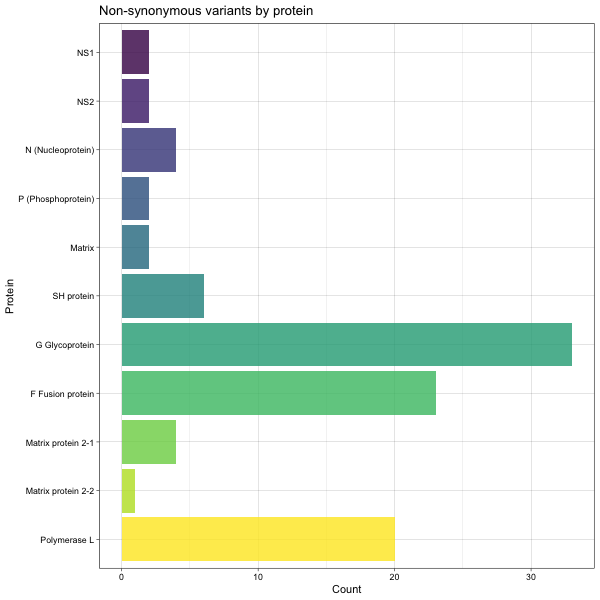

Temporary file deleted successfully.


In [217]:
# barplot of variant frequencies

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
library(dplyr)
p <- variants %>% filter(is_synonymous == "No") %>% 
  arrange(desc(start_pos)) %>% 
  mutate(protein = factor(protein, levels = unique(protein))) %>%
  ggplot(aes(x = protein, fill = protein)) +
  geom_bar(stat = "count") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Non-synonymous variants by protein", x = "Protein", y = "Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end


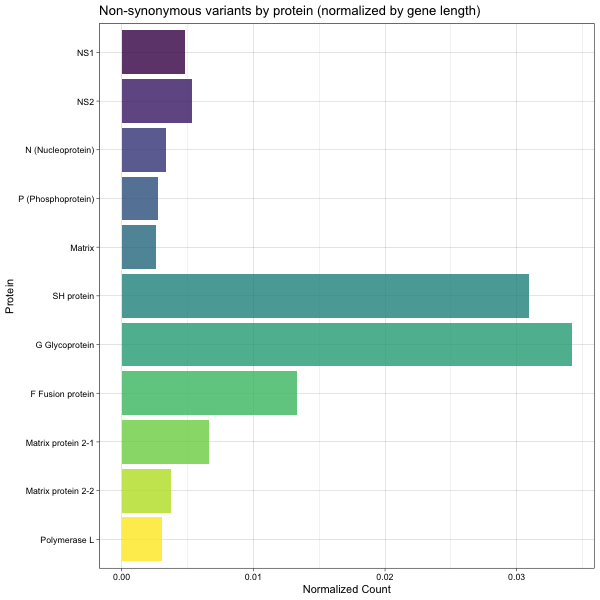

Temporary file deleted successfully.


In [218]:
# barplot of variant frequencies relative to gene length

@rput variants  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
library(dplyr)

# Summarize the data
summary_data <- variants %>%
  filter(is_synonymous == "No") %>%
  group_by(protein, gene_length) %>%
  summarise(count = n(), start_pos = max(start_pos), .groups = 'drop') %>%
  mutate(normalized_count = count / gene_length) %>%
  arrange(desc(start_pos))

# Create the ggplot
p <- summary_data %>%
  mutate(protein = factor(protein, levels = unique(protein))) %>%
  ggplot(aes(x = protein, y = normalized_count, fill = protein)) +
  geom_bar(stat = "identity") +
  theme_linedraw() +
  theme(legend.position = "bottom") +
  labs(title = "Non-synonymous variants by protein (normalized by gene length)", 
       x = "Protein", y = "Normalized Count") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

In [219]:
# generate opportunities in fasta_df

# Load R functions into the R environment
R"""
get_amino_acid <- function(codon) {
  codon_table <- c(
    'TTT' = 'F', 'TTC' = 'F', 'TTA' = 'L', 'TTG' = 'L',
    'CTT' = 'L', 'CTC' = 'L', 'CTA' = 'L', 'CTG' = 'L',
    'ATT' = 'I', 'ATC' = 'I', 'ATA' = 'I', 'ATG' = 'M',
    'GTT' = 'V', 'GTC' = 'V', 'GTA' = 'V', 'GTG' = 'V',
    'TCT' = 'S', 'TCC' = 'S', 'TCA' = 'S', 'TCG' = 'S',
    'CCT' = 'P', 'CCC' = 'P', 'CCA' = 'P', 'CCG' = 'P',
    'ACT' = 'T', 'ACC' = 'T', 'ACA' = 'T', 'ACG' = 'T',
    'GCT' = 'A', 'GCC' = 'A', 'GCA' = 'A', 'GCG' = 'A',
    'TAT' = 'Y', 'TAC' = 'Y', 'TAA' = '*', 'TAG' = '*',
    'CAT' = 'H', 'CAC' = 'H', 'CAA' = 'Q', 'CAG' = 'Q',
    'AAT' = 'N', 'AAC' = 'N', 'AAA' = 'K', 'AAG' = 'K',
    'GAT' = 'D', 'GAC' = 'D', 'GAA' = 'E', 'GAG' = 'E',
    'TGT' = 'C', 'TGC' = 'C', 'TGA' = '*', 'TGG' = 'W',
    'CGT' = 'R', 'CGC' = 'R', 'CGA' = 'R', 'CGG' = 'R',
    'AGT' = 'S', 'AGC' = 'S', 'AGA' = 'R', 'AGG' = 'R',
    'GGT' = 'G', 'GGC' = 'G', 'GGA' = 'G', 'GGG' = 'G'
  )
  return(codon_table[[codon]])
}

mutate_codon <- function(codon) {
  bases <- c('A', 'C', 'G', 'T')
  mutations <- list()
  for (i in 1:nchar(codon)) {
    original_base <- substr(codon, i, i)
    for (base in bases) {
      if (base != original_base) {
        mutated_codon <- substring(codon, 1, i - 1)
        mutated_codon <- paste0(mutated_codon, base, substring(codon, i + 1))
        mutations[[length(mutations) + 1]] <- mutated_codon
      }
    }
  }
  return(mutations)
}

count_mutations <- function(sequence) {
  opportunity_s <- 0
  opportunity_ns <- 0
  for (i in seq(1, nchar(sequence) - 2, by = 3)) {
    codon <- substring(sequence, i, i + 2)
    amino_acid <- get_amino_acid(codon)
    mutations <- mutate_codon(codon)
    for (mutated_codon in mutations) {
      mutated_amino_acid <- get_amino_acid(mutated_codon)
      if (mutated_amino_acid == amino_acid) {
        opportunity_s <- opportunity_s + 1
      } else {
        opportunity_ns <- opportunity_ns + 1
      }
    }
  }
  return(c(opportunity_s, opportunity_ns))
}
"""

# Julia function that uses R functions to process a DataFrame
function count_opportunity(df::DataFrame)
    opportunities = [rcall(:count_mutations, df[i, :sequence]) for i in 1:nrow(df)]
    df.opportunity_s = Int.(getindex.(opportunities, 1))
    df.opportunity_ns = Int.(getindex.(opportunities, 2))
    return df
end


fasta_df = count_opportunity(fasta_df)

println(fasta_df)


11×7 DataFrame
 Row │ protein             start_pos  end_pos  sequence                           n_codons  opportunity_s  opportunity_ns 
     │ String              Int64      Int64    String                             Int64     Int64          Int64          
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…       139            249            1011
   2 │ NS2                       606      980  ATGGACACAACACACAATGATACCACACCACA…       124            229             896
   3 │ N (Nucleoprotein)        1094     2293  ATGAAAGATGGGGCAAATACAAAAATGGCTCT…       399            756            2844
   4 │ P (Phosphoprotein)       2325     3050  ATGGAAAAGTTTGCTCCTGAATTCCATGGAGA…       241            448            1730
   5 │ Matrix                   3233     4003  ATGGAAACATACGTGAATAAACTTCACGAAGG…       256            518            1795
   6 │

In [220]:
# add variant counts

# Send DataFrames to R
@rput variants
@rput fasta_df

# Use R to process the data
R"""
library(dplyr)

# Convert the DataFrame to a tibble
variants <- as_tibble(variants)

# Split the data into synonymous and non-synonymous groups, then count
synonymous_counts <- variants %>%
  filter(is_synonymous == "Yes") %>%
  group_by(protein) %>%
  summarise(s_count = n(), .groups = 'drop')

nonsynonymous_counts <- variants %>%
  filter(is_synonymous == "No") %>%
  group_by(protein) %>%
  summarise(ns_count = n(), .groups = 'drop')

# Join the counts back into one DataFrame
counts <- left_join(synonymous_counts, nonsynonymous_counts, by = "protein")

# Join counts with the original 'fasta_df' DataFrame to include all original data
count_data <- left_join(fasta_df, counts, by = "protein")
"""

# Retrieve the 'count_data' DataFrame back into Julia
@rget count_data

println(count_data)

11×9 DataFrame
 Row │ protein             start_pos  end_pos  sequence                           n_codons  opportunity_s  opportunity_ns  s_count  ns_count 
     │ String              Int64      Int64    String                             Int64     Int64          Int64           Int64    Int64    
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…       139            249            1011        1         2
   2 │ NS2                       606      980  ATGGACACAACACACAATGATACCACACCACA…       124            229             896        1         2
   3 │ N (Nucleoprotein)        1094     2293  ATGAAAGATGGGGCAAATACAAAAATGGCTCT…       399            756            2844        2         4
   4 │ P (Phosphoprotein)       2325     3050  ATGGAAAAGTTTGCTCCTGAATTCCATGGAGA…       241            448            1730        3      

In [221]:
# generate maximum likelihood estimate of the proportion of synonymous variants by protein

function ns_likelihood(df::DataFrame)
    if !hasproperty(df, :s_count) || !hasproperty(df, :ns_count)
        throw(ArgumentError("DataFrame must contain s_count and ns_count columns"))
    end
    
    # Initialize vectors to store results
    likelihood_vals = Float64[]
    mle_p_vals = Float64[]
    range_lower_bounds = Float64[]
    range_upper_bounds = Float64[]
    
    # Define the likelihood function
    function likelihood(p, s_count, ns_count)
        binomial_coeff = binomial(s_count + ns_count, ns_count)
        likelihood_val = binomial_coeff * p^ns_count * (1 - p)^s_count
        return likelihood_val
    end

    # Define the log-likelihood function
    function log_likelihood(p, s_count, ns_count)
        if p <= 0 || p >= 1
            return -Inf  # log(0) is undefined, so return a large negative number
        end
        return log(likelihood(p, s_count, ns_count))
    end

    # Define the negative log-likelihood function for optimization
    function neg_log_likelihood(p, s_count, ns_count)
        return -log_likelihood(p, s_count, ns_count)
    end

    # Iterate over each row of the dataframe
    for row in eachrow(df)
        s_count = row.s_count
        ns_count = row.ns_count
        
        # Optimize the negative log-likelihood to find the MLE of p for this row
        result = optimize(p -> neg_log_likelihood(p, s_count, ns_count), 0.0, 1.0)
        mle_p = Optim.minimizer(result)
        push!(mle_p_vals, mle_p)
        
        # Calculate likelihood and log-likelihood using mle_p
        likelihood_val = likelihood(mle_p, s_count, ns_count)
        log_likelihood_max = log_likelihood(mle_p, s_count, ns_count)
        push!(likelihood_vals, likelihood_val)
        
        # Find the range of p that gives log-likelihood within 2 units of the maximum
        log_likelihood_diff = p -> log_likelihood_max - log_likelihood(p, s_count, ns_count) - 2
        
        lower_bound = find_zero(log_likelihood_diff, (0.0, mle_p))
        upper_bound = find_zero(log_likelihood_diff, (mle_p, 1.0))
        
        push!(range_lower_bounds, lower_bound)
        push!(range_upper_bounds, upper_bound)
    end

    # Add new columns to the dataframe
    df.max_likelihood = likelihood_vals
    df.mle_p = mle_p_vals
    df.p_range_lower = range_lower_bounds
    df.p_range_upper = range_upper_bounds

    return df
end


# Calculate likelihood, and maximum likelihood estimate of p
count_data = ns_likelihood(count_data)

# Display the updated dataframe
println(count_data)


11×13 DataFrame
 Row │ protein             start_pos  end_pos  sequence                           n_codons  opportunity_s  opportunity_ns  s_count  ns_count  max_likelihood  mle_p     p_range_lower  p_range_upper 
     │ String              Int64      Int64    String                             Int64     Int64          Int64           Int64    Int64     Float64         Float64   Float64        Float64       
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…       139            249            1011        1         2        0.444444  0.666667      0.153941        0.979085
   2 │ NS2                       606      980  ATGGACACAACACACAATGATACCACACCACA…       124            229             896        1         2        0.444444  0.666667      0.153941        0.979

In [222]:
# calculate dN/dS 

function dnds(df::DataFrame)
    # Check if the required columns are present
    required_columns = [:mle_p, :opportunity_s, :opportunity_ns, :p_range_lower, :p_range_upper]
    for col in required_columns
        if !hasproperty(df, col)
            throw(ArgumentError("DataFrame must contain $col column"))
        end
    end

    # Initialize columns for dNdS values
    dnds_vals = Float64[]
    dnds_range_lower_vals = Float64[]
    dnds_range_upper_vals = Float64[]

    # Calculate dNdS for each row
    for row in eachrow(df)
        p = row.mle_p
        p_lower = row.p_range_lower
        p_upper = row.p_range_upper
        os = row.opportunity_s
        on = row.opportunity_ns

        if on == 0 || (1 - p) == 0
            push!(dnds_vals, NaN)  # Handle division by zero
        else
            dnds_val = (os * p) / (on * (1 - p))
            push!(dnds_vals, dnds_val)
        end

        if on == 0 || (1 - p_lower) == 0
            push!(dnds_range_lower_vals, NaN)  # Handle division by zero
        else
            dnds_lower_val = (os * p_lower) / (on * (1 - p_lower))
            push!(dnds_range_lower_vals, dnds_lower_val)
        end

        if on == 0 || (1 - p_upper) == 0
            push!(dnds_range_upper_vals, NaN)  # Handle division by zero
        else
            dnds_upper_val = (os * p_upper) / (on * (1 - p_upper))
            push!(dnds_range_upper_vals, dnds_upper_val)
        end
    end

    # Add the new columns to the dataframe
    df.dnds = dnds_vals
    df.dnds_range_lower = dnds_range_lower_vals
    df.dnds_range_upper = dnds_range_upper_vals

    return df
end

# Calculate dNdS
count_data = dnds(count_data)

# Display the updated dataframe
println(count_data)

11×16 DataFrame
 Row │ protein             start_pos  end_pos  sequence                           n_codons  opportunity_s  opportunity_ns  s_count  ns_count  max_likelihood  mle_p     p_range_lower  p_range_upper  dnds      dnds_range_lower  dnds_range_upper 
     │ String              Int64      Int64    String                             Int64     Int64          Int64           Int64    Int64     Float64         Float64   Float64        Float64        Float64   Float64           Float64          
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ NS1                        77      496  ATGGGCAGCAACTCATTGAGTATGATAAAAGT…       139            249            1011        1         2        0.444444  0.666667      0.153941        0.979085  0.492582        0.0448126          11.5293
   2 │ NS2 

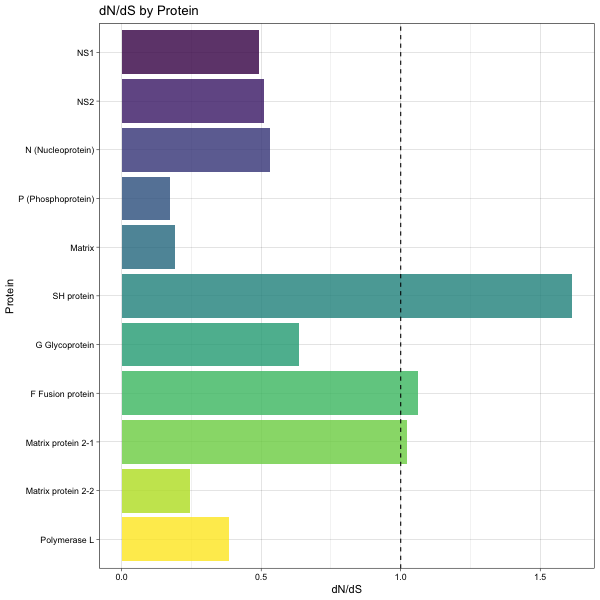

Temporary file deleted successfully.


In [223]:
# barplot of dn/dS

@rput count_data  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- count_data %>% arrange(desc(start_pos)) %>% 
  mutate(protein = factor(protein, levels = unique(protein))) %>%
  ggplot(aes(x = protein, y = dnds, fill = protein)) +
  geom_bar(stat = "identity") +
  theme_linedraw() +
  labs(title = "dN/dS by Protein", x = "Protein", y = "dN/dS") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "black") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end

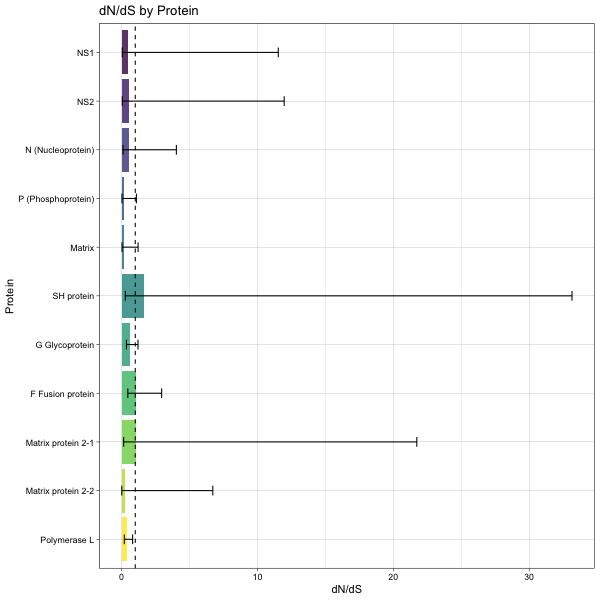

Temporary file deleted successfully.


In [224]:
# barplot of dn/dS with error bars

@rput count_data  # Send the DataFrame to R environment

# Set the path for the temporary image file
output_path = joinpath(pwd(), "ggplot_output.png")

# Create the ggplot in R and save it as a PNG file
R"""
library(ggplot2)
library(viridis)
p <- count_data %>% arrange(desc(start_pos)) %>% 
  mutate(protein = factor(protein, levels = unique(protein))) %>%
  ggplot(aes(x = protein, y = dnds, fill = protein)) +
  geom_bar(stat = "identity") +
  geom_errorbar(aes(ymin = dnds_range_lower, ymax = dnds_range_upper), width = 0.2) +
  theme_linedraw() +
  labs(title = "dN/dS by Protein", x = "Protein", y = "dN/dS") +
  scale_fill_viridis(discrete = TRUE, alpha = 0.8, direction = -1) +
  theme(legend.position = "none") +
  geom_hline(yintercept = 1, linetype = "dashed", color = "black") +
  coord_flip()

png(filename = $output_path, width = 600, height = 600)
print(p)
dev.off()
"""

# Read and display the image file in Julia
if isfile(output_path)
    img = load(output_path)
    display(img)

    # Delete the temporary image file after displaying
    rm(output_path; force = true)
    println("Temporary file deleted successfully.")
else
    println("File does not exist.")
end